# Case Study on Loss Given Default

# Context: 
    
CNB Bank deals in all kinds of car loans. Customer first apply for loan after that company validates the customer 
eligibility for loan. In case the borrower doesn’t pay back the loan, the losses are to be incurred by the bank.
LGD stands for Loss given default so it means when a customer at a bank defaults on his loan how much money does the bank lose. 
The customer might have paid some amount back or no amount at all.The bank wants to know if the amount the bank loses can be 
predicted for new customers who apply for a loan from the past data of all defaulters and their pending amounts

# Problem:

The bank wants to automate the loss estimation based on customer detail provided while applying for loan. These details are Age, 
Years of Experience, Number of cars, Gender, Marital Status. To automate this process, they have given a problem to identify the 
loss estimation given that the customers is a defaulter, those are eligible for loan amount so that they get to know what 
features are leading to defaults up to which amount. Here are the details about the data set.

Data:

Variable - Description <br>
Ac_No - The account of customer used as identifier <br>
Age - Age of borrower (16-70) <br>
Years of Experience -  Working experience (0-53) <br>
Number of Cars - Possessed cars (1, 2, 3, 4) <br>
Gender - Male/Female <br>
Married - Married/Single <br>
Loss in Thousands - Target variable <br>


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd                                             # library for working with dataframes
import numpy as np                                              # library for working with arrays
import matplotlib.pyplot as plt                                 # low level visualization library
%matplotlib inline
import seaborn as sns                                           # higher level visualization library compared to matplotlib

In [4]:
# Adjust pandas display and formatting settings

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format        

# Increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Update default style and size of charts
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [10, 8]

# Increase max number of rows and columns to display in pandas tables
pd.set_option('display.max_columns', 500)           
pd.set_option('display.max_rows', 500) 

seed = 6

In [5]:
# read the csv file into a dataframe
df=pd.read_csv("LGD.csv")

In [6]:
# lets do a basic EDA ( exploratory data analysis) on the file
df.info() # this tells us 15290 rows & 7 columns
#df.shape will also give the same info
#df.info also tells us there are no NULL values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15290 entries, 0 to 15289
Data columns (total 7 columns):
Ac_No                  15290 non-null int64
Age                    15290 non-null int64
Years of Experience    15290 non-null int64
Number of Vehicles     15290 non-null int64
Gender                 15290 non-null object
Married                15290 non-null object
Losses in Thousands    15290 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 836.3+ KB


In [7]:
df.head()

,Ac_No,Age,Years of Experience,Number of Vehicles,Gender,Married,Losses in Thousands
0,150024,24,5,1,M,Married,203.32
1,144880,31,10,1,F,Single,402.20
2,133742,56,37,1,M,Married,553.13
3,151282,52,31,1,F,Married,292.43
4,174407,20,3,1,M,Single,246.54


## George's Challenge
- Each column's variable type?
- How to handle categorical variables in linear regression?
- Based on what we discussed last time, is this data "long" or "wide"?

In [8]:
df.nunique()
# To check number of unique values in a particular column

Ac_No                  15290
Age                       55
Years of Experience       54
Number of Vehicles         4
Gender                     2
Married                    2
Losses in Thousands    15289
dtype: int64

In [9]:
df.drop('Ac_No',axis=1,inplace=True)

# As all the values are unique in the column, it doen't help our model to predict anything

In [11]:
df['Number of Vehicles'].value_counts(normalize=True).sort_index()

# checking the distribution of vehicles
# Number of vehicles 2 and 3 seems common

1   0.17
2   0.34
3   0.33
4   0.16
Name: Number of Vehicles, dtype: float64

## George's Tip
There's a similar method that's called `sort_values` https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html

In [13]:
pd.pivot_table(df,values='Losses in Thousands',index='Gender',columns='Married',aggfunc='mean')

# checking distrbution of losses for female and male, and comparing their marital status as well
# single men have more losses
# Single people overall have more                                                                losses than married people

Married,Married,Single
Gender,,
F,290.04,400.24
M,358.91,517.18


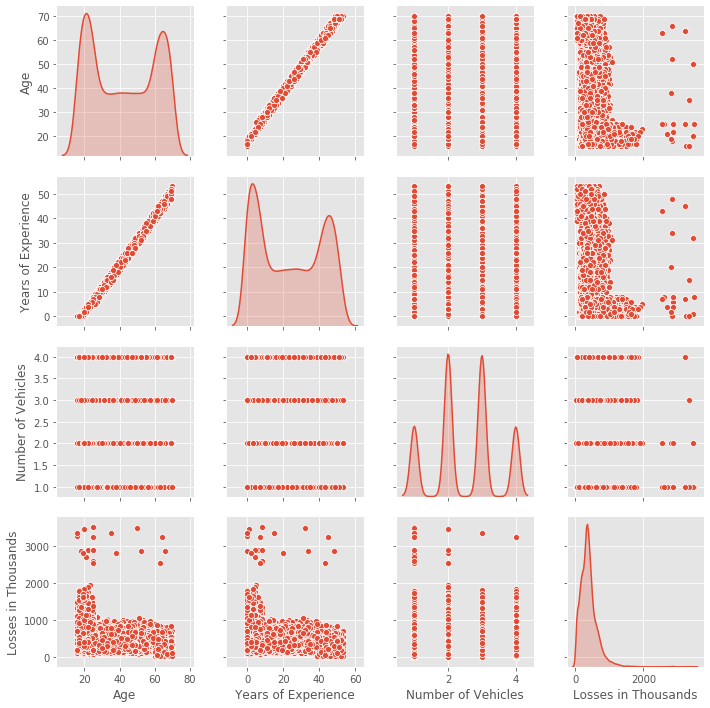

In [16]:
sns.pairplot(df, diag_kind='kde')
plt.show()

In [12]:
# A lot of people on younger and older side
# more number of people with high and low years of experience are present in the data

# Losses distrubution is skewed towards positive side

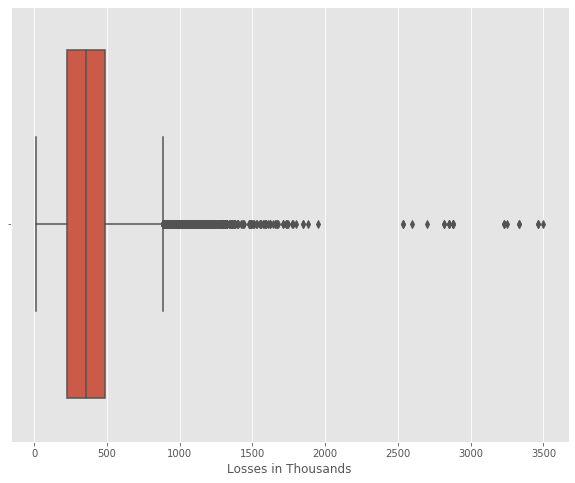

In [17]:
sns.boxplot(df['Losses in Thousands'])
plt.show()

# Outliers are present, few people have extreme losses
# Removing outliers here will create biasness

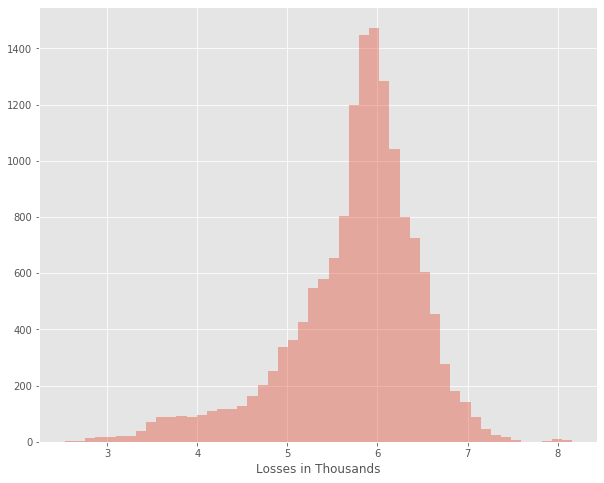

In [18]:
# this probably means we should take the log to normalize the data

sns.distplot(np.log(df['Losses in Thousands']),kde=False,bins=50)
plt.show()
# now the distribution looks normal

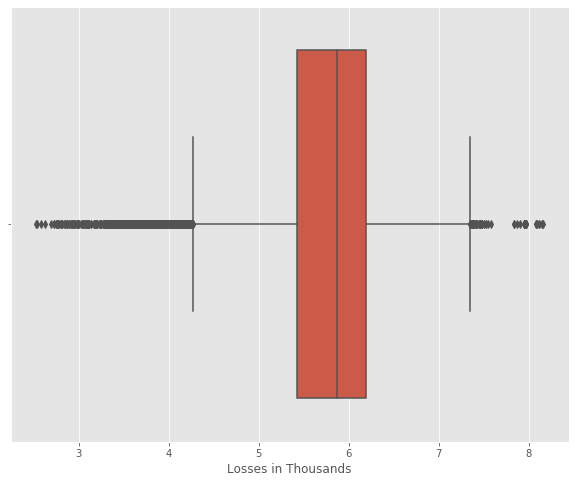

In [19]:
sns.boxplot(np.log(df['Losses in Thousands']))
plt.show()

## George's Tip
Why and when do we do log transformation? 
- to make values comparable! 
- https://datascience.stackexchange.com/questions/40089/what-is-the-reason-behind-taking-log-transformation-of-few-continuous-variables


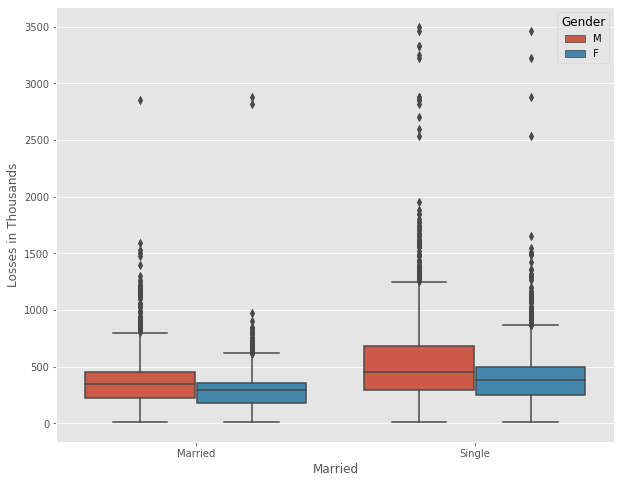

In [21]:
sns.boxplot(x="Married",y="Losses in Thousands",data=df,hue="Gender")
plt.show()

#this shows that single ppl & Male are the worst

In [22]:
df.corr()

# we see a high co-relation between Age and Years of Experience 

# which is obvious as with Age your Experience increases

,Age,Years of Experience,Number of Vehicles,Losses in Thousands
Age,1.00,1.00,0.01,-0.44
Years of Experience,1.00,1.00,0.01,-0.44
Number of Vehicles,0.01,0.01,1.00,-0.01
Losses in Thousands,-0.44,-0.44,-0.01,1.00


## George's Challenge
What's a good option for visualizing correlation matricies?

In [23]:
# first lets build a simple model with all variables and as is
# we will have to convert the string variables to dummy variables 
dummy_df=pd.get_dummies(df,drop_first=True)

**This will convert the object type or categorical type columns, into different columns**

**for example: 'Gender' has two categories 'M' and 'F', so the two columns 'Gender_F' and 'Gender_M' will be formed because of get dummies and Gender column will be dropped**

**Now because of `drop_first = True` one column of each category will be dropped, here 'Gender_F' is dropped**

dropping column is logical because if the gender is not male it will be female it is assumed, that extra column adds no value. Even if gender had three categories 'female', 'male' and 'other' then also dropping one made sense, because if its not in 'male' or 'other' then it has to be 'female'.

In [24]:
dummy_df.head()

,Age,Years of Experience,Number of Vehicles,Losses in Thousands,Gender_M,Married_Single
0,24,5,1,203.32,1,0
1,31,10,1,402.20,0,1
2,56,37,1,553.13,1,0
3,52,31,1,292.43,0,0
4,20,3,1,246.54,1,1


## George's Challenge
Why is it okay to drop a column?

In [25]:
#decide your regressor and predictor variables

x=dummy_df.drop("Losses in Thousands",axis=1)
y=dummy_df["Losses in Thousands"]

#split the data into train and test
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=7)


from sklearn.linear_model import LinearRegression # import the functions
lm=LinearRegression() #call the function
lm.fit(x_train,y_train)# fit the model
print("Intercept of the linear equation:",lm.intercept_) # see the intercept
print()
print("COefficients of the equation are:")
print(lm.coef_)# see the coefficients
print()

#see the error parameters
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#make prediction
pred=lm.predict(x_test) #predicting values of y for all the xtest rows

print("Mean Absolute Error:",mean_absolute_error(y_test,pred))
print()
print("RMSE:",mean_squared_error(y_test,pred)**0.5)
print()
print("R2 Squarred:",r2_score(y_test, pred))

Intercept of the linear equation: 493.6945343712489

COefficients of the equation are:
[ -3.33228812  -2.85132298  -2.94696675  93.71284928 135.90322285]

Mean Absolute Error: 145.26196429799884

RMSE: 211.9130120020698

R2 Squarred: 0.3076551955553346


## George's Tip
Reproducibility is a BIG issue in machine learning, random state fixing is a major help! 

In [26]:
x_test.head()

,Age,Years of Experience,Number of Vehicles,Gender_M,Married_Single
13812,18,1,4,0,0
7190,20,3,2,0,1
4582,37,19,2,0,0
9221,28,8,3,0,0
13129,25,7,4,0,1


**So the equation is:**

Losses in Thousand = 493.69 -3.33 (Age) -2.85 (Years of Experience) -2.9 (Number of Vehicles) +93.71 (Gender_M) +135.9 (Married_Single)

In [27]:
import statsmodels.api as sm

X2 = sm.add_constant(x_train)
# sm.OLS by default does not add an intercept in the model.
#so we manually added it by the first line

lm= sm.OLS(y_train,X2).fit()

print("Pvalues for each column:")
print()
print(lm.pvalues)

Pvalues for each column:

const                 0.00
Age                   0.02
Years of Experience   0.06
Number of Vehicles    0.17
Gender_M              0.00
Married_Single        0.00
dtype: float64


In [28]:
#to see the summary
print(lm.summary())

                             OLS Regression Results                            
Dep. Variable:     Losses in Thousands   R-squared:                       0.299
Model:                             OLS   Adj. R-squared:                  0.299
Method:                  Least Squares   F-statistic:                     914.4
Date:                 Sat, 25 Jul 2020   Prob (F-statistic):               0.00
Time:                         11:16:29   Log-Likelihood:                -72519.
No. Observations:                10703   AIC:                         1.451e+05
Df Residuals:                    10697   BIC:                         1.451e+05
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 49

## George's Tip
- R Squared vs. Adjusted R Squared  https://blog.minitab.com/blog/adventures-in-statistics-2/multiple-regession-analysis-use-adjusted-r-squared-and-predicted-r-squared-to-include-the-correct-number-of-variables
- Covariance vs. Correlation  
https://towardsdatascience.com/let-us-understand-the-correlation-matrix-and-covariance-matrix-d42e6b643c22        
https://acadgild.com/blog/covariance-and-correlation

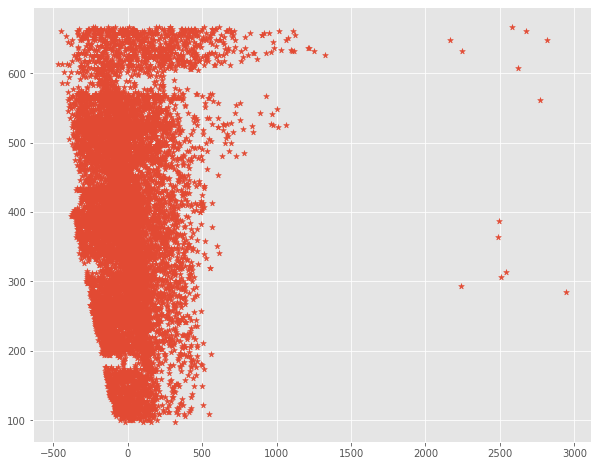

In [29]:
plt.scatter(lm.resid, lm.predict(),marker='*') # Plot between residual(actual - predicted) and predicted values
plt.show()

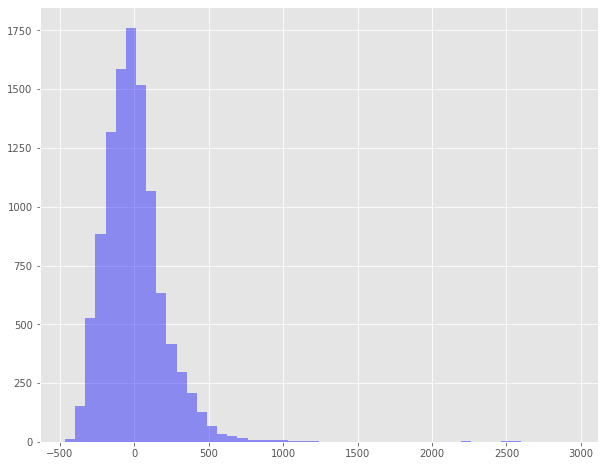

In [30]:
# error distribution
sns.distplot(lm.resid, hist=True, kde=False, color = 'blue')
plt.show()

## George's Tip
- Different color pallettes in Seaborn  https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/

In [24]:
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
# training Score
regression_model.score(x_train, y_train)

0.2994352317206177

In [26]:
#testing score
regression_model.score(x_test, y_test)

0.3076551955553345

## George's Challenge
What is the score measuring? How to find out?

In [27]:
#RMSE
mean_squared_error(y_test,regression_model.predict(x_test))**0.5

211.91301200206982

#### Conclusion:

1. Here Training score is better than Testin score, therefore model is overfit


2. Score here measures R2_score, and 0.307 score says that only 30 % of variation were explained by the model, higher the r2 score better it is.


3. RMSE gives you on average how much the predicted value is deviating from observed value, 211K variation in losses is a lot.


4. Looking at RMSE and R2 score we can say that model is not good enough.

### Applying log to target variable for normal distribution

In [28]:
loss = dummy_df['Losses in Thousands']
# Storing the original value of losses

In [29]:
dummy_df['Losses in Thousands'] = np.log(dummy_df['Losses in Thousands'])
#applying log to change the distribution as normal

In [30]:
x=dummy_df.drop("Losses in Thousands",axis=1)
y=dummy_df["Losses in Thousands"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=7)
regression_model = LinearRegression()
regression_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
# training Score
regression_model.score(x_train, y_train)

0.32587614490318095

In [32]:
#testing score
regression_model.score(x_test, y_test)

0.33182355678770625

In [33]:
#RMSE
mean_squared_error(y_test,regression_model.predict(x_test))**0.5

0.5965781071917762

**Visualization using yellowbrick**

In [34]:
# library for visualizing result of your model. Install through jupyter terminal using: pip install yellowbrick
from yellowbrick.regressor import ResidualsPlot

# Visualize errors of the model, Plot between residual(actual - predicted) and predicted values using ye
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show();                # Finalize and render the figure

ModuleNotFoundError: No module named 'yellowbrick'

## George's Tip
- You can run terminal/CMD/Shell command directly in Jupyter by adding a `!` sign at the beginning, so you can install here too, as long as you don't have to confirm anything.
- Just google `conda install [package name]` to find the command to use for installing any package in Anaconda

In [35]:
!conda install -c districtdatalabs yellowbrick

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::python-graphviz==0.14=py_0
  - defaults/linux-64::anaconda==custom=py37_1
  - defaults/linux-64::pango==1.42.4=h049681c_0
  - defaults/linux-64::_anaconda_depends==2020.02=py37_0
  - defaults/linux-64::graphviz==2.40.1=h21bd128_2
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /home/george/anaconda3

  added / updated specs:
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.6.24  |                0         125 KB
    certifi-2020.6.20          |           py37_0         156 KB
    pytest-

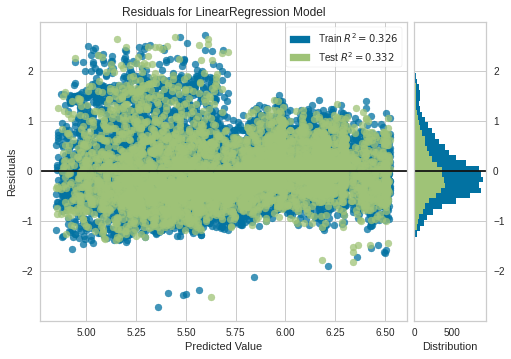

In [36]:
# library for visualizing result of your model. Install through jupyter terminal using: pip install yellowbrick
from yellowbrick.regressor import ResidualsPlot

# Visualize errors of the model, Plot between residual(actual - predicted) and predicted values using ye
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show();                # Finalize and render the figure

#### Conclusion:

1. Here Testing score is better than Training score, therefore model is good fit


2. R2_score is 0.33, that only explains 33 % of total variation in the dataset. Better than previous case but overall its not satisfactory


3. RMSE value doesnt make sense here log of losses is taken.


4. Looking at R2 score we can say that model is not good enough.

## George's Bonus
- Algorithm vs. Model  https://machinelearningmastery.com/difference-between-algorithm-and-model-in-machine-learning/
- Data splitting in ML